# TODO
**BE SURE TO ADD PATH TO `src/*` TO YOUR `ENVIROMENT/LIB/PYTHONVESRION/SITEPACKAGE/tnn.pth`** !
# Introduction to Tree NN

## Trees and DecisionUnits

In [2]:
from tnn import DecisionUnit, Tree
from models import Id
import torch
import torch.nn as nn

# simple model
class Double(nn.Module):
    def forward(self, x, training=None):
        return 2 * x

# tree either doubles x or leaves it
tree= Tree(1, [Id, Double()])

# For educational purpuses:
# We will set bias to 0 and weights to 0.5
# and get an uniform distribution over paths 
with torch.no_grad():
    tree.distribution.linear.weight.fill_(0.5)
    tree.distribution.linear.bias.fill_(0)

Lets sample a few outputs of this simple tree for input $[1]$ and calculate $E([1])$

In [43]:
x = torch.ones((1,))
print(f"input = {x}")
for i in range(5):
    print(tree(x, select_max=False).item(), end=";  " )
print()


E = tree.expected_value(lambda z : z,x)
print(f"E(Tree(x)) = {E}")

# batched input:
print("\nBATCHED INPUT:")
batch = torch.tensor([[0], [1], [2], [3]], dtype=torch.float)
print("input=\n", batch, "\n")

E = tree.expected_value(lambda z : z,batch)
print(f"E(Tree(batch)) = {E}")


raise NotImplementedError
tree(batch, select_max=False)

input = tensor([1.])
1.0;  2.0;  2.0;  2.0;  1.0;  
E(Tree(x)) = tensor([1.5000], grad_fn=<ViewBackward0>)

BATCHED INPUT:
input=
 tensor([[0.],
        [1.],
        [2.],
        [3.]]) 

E(Tree(batch)) = tensor([[0.0000],
        [1.5000],
        [3.0000],
        [4.5000]], grad_fn=<SumBackward1>)


NotImplementedError: 

# Training
Different mothods of training will be shown. We will try to model a following function:
$$
f(x,y) = \begin{cases}
xy & x > 0, y > 0 \\
x + y & x > 0, y \leq  0 \\
2x \leq  0, y \leq  0 \\ 
y & x \leq 0, y > 0 \\
\end{cases}
$$

In [3]:
def f(x, y):
    if x > 0:
        if y > 0:
            return x * y 
        else:
            return x + y
    else:
        if y > 0:
            return y 
        else:
            return 2*x 

def vector_f(z):
    return f(z[0], z[1])

# get training data:
n_points = 100
n_data = n_points ** 2 
points = torch.linspace(-5, 5, n_points)
X = torch.zeros((n_data, 2))
Z = torch.zeros((n_data, 1))
for index_x in range(n_points):
    for index_y in range(n_points):
        x = points[index_x]
        y = points[index_y]
        X[index_y + index_x * n_points] = torch.tensor([x, y])
        Z[index_y + index_x * n_points] = f(x, y)

# get testing data:
n_points_training = 31
n_data_training = n_points_training ** 2 
points = torch.linspace(-5, 5, n_points_training)
test_X = torch.zeros((n_data_training, 2))
test_Z = torch.zeros((n_data_training, 1))
for index_x in range(n_points_training):
    for index_y in range(n_points_training):
        x = points[index_x]
        y = points[index_y]
        test_X[index_y + index_x * n_points_training] = torch.tensor([x, y])
        test_Z[index_y + index_x * n_points_training] = f(x, y)



In [4]:
for i in range(X.shape[0]):
    if not (Z[i] == vector_f(X[i])):
        raise ValueError
X.shape, Z.shape

(torch.Size([10000, 2]), torch.Size([10000, 1]))

## Shallow Tree model

In [5]:
from models import FeedForward
tree = Tree(2, [FeedForward(2, 3, 1), FeedForward(2, 3, 1)])
tree.n_params()

32

## Baseline 
We will compare the performance of different training settings to different simple Feedforward networks with the similar numbers of parameters

In [6]:
# tree has  6 + 13 + 13 = 32 parameters (6 for decision unit, 13 for Feedforward networks)
n_params = tree.n_params()
baseline_models = [FeedForward(2,4,3 , 1), FeedForward(2,4,4,1), FeedForward(2, 8, 1)   ]

In [7]:
from torch.optim import Adam
from tqdm import tqdm
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau

optimisers = [Adam(model.parameters(), lr=0.01) for model in baseline_models]


opt = optimisers[0]
scheduler = ReduceLROnPlateau(opt, 'min', factor=0.7)
model = baseline_models[0]

n_epoch = 1000
batch_size = 200
mse = torch.nn.MSELoss()


training_errors = []
validation_errors = [] 

for epoch in tqdm(range(n_epoch), total=n_epoch):
    for batch_index in range(n_data // batch_size):
        ############
        # get batch
        ############

        start = batch_size * batch_index
        stop = batch_size * (batch_index + 1)
        if batch_index == (n_data // batch_size) - 1:
            stop = n_data
        batchX = X[start:stop]
        batchZ = Z[start:stop]

        ############
        # train on batch
        ############

        # reset gradients
        opt.zero_grad()
        # get predictions and cost function
        outputs = model(batchX)
        loss = mse(outputs, batchZ)
        # calculate gradients
        loss.backward()
        # one step of optimisation
        opt.step()
    

    # collect results
    training_error = mse(model(X), Z)
    validation_error = mse(model(test_X), test_Z)
    training_errors.append(training_error)
    validation_errors.append(validation_error)


    # change learnign rate
    scheduler.step(validation_error)

    if epoch % 100 == 0:
        print(f"Epoch #{epoch +1}: Training error: {training_error}, validaion error: {validation_error}")

  0%|          | 2/1000 [00:00<01:23, 11.99it/s]

Epoch #1: Training error: 28.823646545410156, validaion error: 31.348154067993164


 10%|█         | 102/1000 [00:07<01:06, 13.45it/s]

Epoch #101: Training error: 13.223487854003906, validaion error: 14.121841430664062


 20%|██        | 202/1000 [00:15<01:03, 12.51it/s]

Epoch #201: Training error: 13.202718734741211, validaion error: 14.537351608276367


 30%|███       | 302/1000 [00:23<00:55, 12.60it/s]

Epoch #301: Training error: 13.38393783569336, validaion error: 14.497243881225586


 40%|████      | 402/1000 [00:31<00:46, 12.74it/s]

Epoch #401: Training error: 13.49802017211914, validaion error: 14.351887702941895


 50%|█████     | 502/1000 [00:39<00:40, 12.30it/s]

Epoch #501: Training error: 13.23112964630127, validaion error: 14.34230899810791


 60%|██████    | 602/1000 [00:47<00:32, 12.11it/s]

Epoch #601: Training error: 13.264890670776367, validaion error: 14.799792289733887


 70%|███████   | 702/1000 [00:55<00:24, 12.34it/s]

Epoch #701: Training error: 13.403862953186035, validaion error: 14.4959716796875


 80%|████████  | 802/1000 [01:03<00:16, 12.26it/s]

Epoch #801: Training error: 13.484347343444824, validaion error: 14.290173530578613


 90%|█████████ | 902/1000 [01:11<00:08, 12.15it/s]

Epoch #901: Training error: 13.251842498779297, validaion error: 13.946998596191406


100%|██████████| 1000/1000 [01:19<00:00, 12.57it/s]


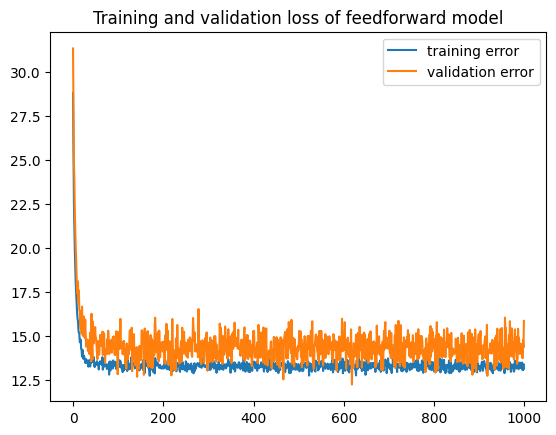

In [8]:
# plot errors
import matplotlib.pyplot as plt

#deatach all 
def deatach_list(lst):
    ans = []
    for x in lst:
        y = x.detach().numpy()
        ans.append(y)
    return ans


plt.plot(deatach_list(training_errors), label="training error")
plt.plot(deatach_list(validation_errors), label="validation error")
plt.legend()
plt.title("Training and validation loss of feedforward model")
plt.show()


## Primitive training without additional cost function
We can just minimalize E[L(x)]. Bad performance expected.

In [10]:
# get new tree
tree = Tree(2, [FeedForward(2, 3, 1), FeedForward(2, 3, 1)])

# train the tree
from torch.optim import Adam
from tqdm import tqdm
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau

optimisers = Adam(tree.parameters(), lr=0.01)


scheduler = ReduceLROnPlateau(opt, "min", factor=0.7)
model = baseline_models[0]

n_epoch = 1000
batch_size = 200
mse = torch.nn.MSELoss()


training_errors = []
validation_errors = []

for epoch in tqdm(range(n_epoch), total=n_epoch):
    for batch_index in range(n_data // batch_size):
        ############
        # get batch
        ############

        start = batch_size * batch_index
        stop = batch_size * (batch_index + 1)
        if batch_index == (n_data // batch_size) - 1:
            stop = n_data
        batchX = X[start:stop]
        batchZ = Z[start:stop]

        ############
        # train on batch
        ############

        # reset gradients
        opt.zero_grad()

        # calculate E[Loss(tree(x))] over the whole batch
        expected_loss = 0
        for x, z in zip(batchX, batchZ):
            expected_loss += tree.expected_value(lambda y: mse(y, z), x)
        expected_loss /= batch_size

        # calculate gradients
        expected_loss.backward()
        # one step of optimisation
        opt.step()

    # collect results
    # training error:
    training_error = 0
    for x, z in zip(X, Z):
        training_error += mse(tree(x), z)
    training_error /= n_data

    validation_error = 0
    for x, z in zip(test_X, test_Z):
        validation_error += mse(tree(x), z)
    validation_error /= n_data

    training_errors.append(training_error)
    validation_errors.append(validation_error)

    # change learnign rate
    scheduler.step(validation_error)

    if epoch % 100 == 0:
        print(
            f"Epoch #{epoch +1}: Training error: {training_error}, validaion error: {validation_error}"
        )

  0%|          | 1/1000 [00:15<4:17:56, 15.49s/it]

Epoch #1: Training error: 26.565563201904297, validaion error: 2.7715392112731934


  1%|▏         | 14/1000 [03:45<4:25:15, 16.14s/it]


KeyboardInterrupt: 

# Primitive training + force softmax to converge to delta 
Mogoče se nam splača forsirat distribucijo (pred softmaxom..?) v to smer, da je na eni točki ful velika, drugje pa mala

In [ ]:
# TODO

# 2-step training of Tree:
We can alternate between training the parameters of the inside linear layers and the parameters of the outside layers.

### Punish small gradients

In [ ]:
# TODO


### Force inner network to be perpendicular to siblings of its parents

Slabo iz tega vidika, da mogoče na koncu  vseeno rabiš prevert kej, na kar smo bli pravkokotni

In [ ]:
#TODO

### Štetje ničel v vektorju za vsakim hidden layerjem

In [ ]:
#TODO

In [ ]:
model = FeedForward(2, 2, 1)
list(model.parameters())

[Parameter containing:
 tensor([[ 0.6564,  0.0949],
         [-0.4895,  0.5235]], requires_grad=True),
 Parameter containing:
 tensor([-0.0227, -0.4053], requires_grad=True),
 Parameter containing:
 tensor([[ 0.6865, -0.1527]], requires_grad=True),
 Parameter containing:
 tensor([0.2924], requires_grad=True)]

In [ ]:
-0.4032  -0.3246   -0.0350

-0.7628

In [ ]:
x = torch.ones((2))
model(x, training=True)

[tensor([ 0.7286, -0.3713], grad_fn=<ViewBackward0>),
 tensor([0.7286, 0.0000], grad_fn=<ReluBackward0>),
 tensor([0.8095, 0.0000], grad_fn=<MulBackward0>),
 tensor([0.8481], grad_fn=<ViewBackward0>)]

In [ ]:

grads = torch.autograd.grad(
outputs=model(x),
inputs=[p for p in model.parameters() if p.requires_grad],
create_graph=True  # allows you to compute gradients of this gradient
)
grads

(tensor([[0.7627, 0.7627],
         [0.0000, 0.0000]], grad_fn=<TBackward0>),
 tensor([0.7627, 0.0000], grad_fn=<ViewBackward0>),
 tensor([[0.8095, 0.0000]], grad_fn=<TBackward0>),
 tensor([1.]))